![title](img/logo.png)
# Biometrics System Concepts
## Assignment 1: Evaluating performance of biometric systems
<b>Name</b>: Marty McFly |
<b>Student-nr</b>: C25 |
<b>Date</b>: June 12, 2015
---

In this assignment we focus on evaluating the performance of any biometric system in a verification and identification setting. 

Before you get started you should be able to properly distinguish verification from identification and know the corresponding validation procedures. If this is not the case for you yet, **review the lecture notes!** We will give a short recap to refresh your memory: 
* **VERIFICATION** (a.k.a. authentication): Authenticating a claimed identity (is this person who he/she claims to be?).

* **IDENTIFICATION**: Associate a particular individual with an identity (who is this unidentified individual?).

This document is structured as follows:

- [I. Reading the data](#I.-Reading-the-data)
- [II. Validation of verification system](#II.-Validation-of-verification-system)
- [III. Validation of identification system](#III.-Validation-of-identification-system)
- [IV. Assignment Instructions](#IV.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of algorithmic components). The code examples in this assignment are just skeleton code,  **adapt where needed! And try to keep things structured!** 

In [13]:
# Install and import the required python packages to run this notebook. Feel free to add more packages whenever needed.

import numpy as np
import matplotlib.pyplot as plt
# the following meta-command is required to get plots displayed in notebooks
%matplotlib inline

# package for reading xml files
import xml.etree.ElementTree as ET

import os

# package for data analysis with fast and flexible data structures
import pandas as pd

# package to show a nice graphical progress-bar for lengthy calculations
# docu and installation on https://tqdm.github.io
# if you have difficulties installing this package: 
# - make sure your jupyter lab is up to date
# - https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637
# - consider just leaving it out (just remove the 'tqdm_notebook' in the code)
from tqdm.notebook import tqdm as tqdm_notebook

# import local modules for reading and converting BSSR1 fingerprint score data
import src.BSSR1 as BSSR1
import pickle

### Adding custom libraries ###
from sklearn import preprocessing

import math
import scipy.stats as stats



<div class="alert alert-block alert-info">
<b>Tip:</b> 
Many operations have already been implemented in <a href="https://docs.scipy.org/doc/numpy/index.html">SciPy</a>, feel free to use them or any other unless explicitely stated not to in the assignment.</div>

## I. Reading the data
In this assignment we focus on the validation of a pre-exising biometric system. We will make use of actual predicted fingerprint similarity scores, from the left and right index fingers. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with that of the same (genuine scores) or another user (impostor scores). The data (biometrics scores set BSSR1) are made available through the American National Institute of Standards and Technologies [(NIST)](https://www.nist.gov/itl/iad/image-group/nist-biometric-scores-set-bssr1). They are provided as part of your assignment folder in the `data/fing-x-fing` subfolder. 

In this code example we will compare the performance of a biometric system that was based on the right index finger to a biometric system based on the left index finger. These systems are referred to as `ri` and `li` respectively in both code and text.  

### 1.1. Loading the similarity matrix and reading the genuine and impostor scores
We provide you with the code to read the scores from the files (normally you can leave this code as-is).

The code consits of 2 steps that are executed for both the `ri` and `li` system: 
1. Scores are converted to similarity matrices. To simplify the task we have provided you with the similarity matrices. You need to load the similarity matrices with the genuine scores on the diagonal and the impostor scores on the off-diagonal elements.  
2. Convert the original scores to a linear list of scores with associated labels of genuine or impostor (simplifies use of [scikit-learn](https://scikit-learn.org/stable/index.html))



In [3]:
# STEP 1: loading the similarity matrices for left and right index fingers
with open('./data/li_similarity_matrix.pickle', 'rb') as f:
    li_similarity_matrix = pickle.load(f)
with open('./data/ri_similarity_matrix.pickle', 'rb') as f:
    ri_similarity_matrix = pickle.load(f)
    
np.set_printoptions(edgeitems=5)
print(np.sort(li_similarity_matrix.values[2])[::-1])
#print(ri_similarity_matrix)

[25. 24. 24. 21. 20. 20. 19. 19. 18. 18. 18. 18. 18. 17. 17. 17. 17. 17.
 17. 17. 17. 17. 16. 16. 16. 16. 16. 16. 16. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 13. 13. 13. 13. 13. 13. 13. 13.
 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 11. 11. 11. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9

In [4]:
# STEP 2: convert to genuine and impostor scores, the *_genuine_id provides a mask for the genuine scores
li_genuine_id, li_scores = BSSR1.sim2scores(li_similarity_matrix)
ri_genuine_id, ri_scores = BSSR1.sim2scores(ri_similarity_matrix)

print(li_genuine_id, li_scores)
print(len(li_genuine_id), li_scores.size)
print(ri_genuine_id, li_scores)

[1. 1. 1. 1. 1. ... 0. 0. 0. 0. 0.] [0.18320611 0.27099237 0.0648855  0.04198473 0.3778626  ... 0.01145038
 0.03053435 0.03053435 0.02290076 0.01145038]
1000000 1000000
[1. 1. 1. 1. 1. ... 0. 0. 0. 0. 0.] [0.18320611 0.27099237 0.0648855  0.04198473 0.3778626  ... 0.01145038
 0.03053435 0.03053435 0.02290076 0.01145038]


<div class="alert alert-block alert-info">
<b>Tip:</b> 
In this assignment we focus only on evaluating biometric systems. It is in your best interest to write your code such that it can easily be reused in the upcoming assignments, where you will have to develop entire biometric system pipelines.</div>

## II. Validation of verification system

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of a verification scenario can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1 for more information). In essence one has a binary classification problem: is it the claimed identity or not? 

We denote our classes as:
<ol start="0">
  <li>Impostor (False),</li>
  <li>Genuine (True).</li>
</ol>

Furthermore, we represent the set of scores as s, the imposter event as $I$ and a genuine event as $G$.

### 1. Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)



#### 1.1 Genuine and impostor score distributions
Given the genuine and impostor scores (from section I), we can plot the imposter $p(s | I)$ and genuine $p(s | G)$ distribution to gain some first insights in the system. The result should look something like this:

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>


<div class="alert alert-block alert-success">
<b>Q1: </b> Score distributions
<ul>
  <li>Plot the genuine and impostor score distributions in a single plot.</li>
  <li>Do you need to normalize the distributions? Why (not)?</li>
  <li>Describe qualitatively this combined plot (hint: limit the score range for better understanding)</li>
</ul>  
</div>

[0.18320611 0.27099237 0.0648855  0.04198473 0.3778626  0.16412214
 0.73282443 0.05343511 0.20992366 0.31679389 0.21374046 0.14885496
 0.02290076 0.24427481 0.39312977 0.63740458 0.02671756 0.26335878
 0.20992366 0.61450382 0.47709924 0.08778626 0.71374046 0.22519084
 0.35496183 0.1259542  0.46946565 0.45419847 0.03816794 0.03053435
 0.35114504 0.02290076 0.58778626 0.15267176 0.06870229 0.48854962
 0.22900763 0.1221374  0.6870229  0.61068702 0.51526718 0.54580153
 0.09541985 0.2480916  0.27862595 0.25572519 0.02671756 0.1870229
 0.36641221 0.13740458 0.35877863 0.32061069 0.11068702 0.59541985
 0.03053435 0.4389313  0.14503817 0.12977099 0.33969466 0.63358779
 0.29389313 0.24427481 0.76335878 0.38549618 0.16030534 0.85877863
 0.17557252 0.33969466 0.52290076 0.04961832 0.42748092 0.12977099
 0.06870229 0.19465649 0.62977099 0.47328244 0.29389313 0.14885496
 0.13740458 0.19083969 0.08015267 0.04580153 0.40458015 0.48091603
 0.44274809 0.11068702 0.82824427 0.40458015 0.31679389 0.47328

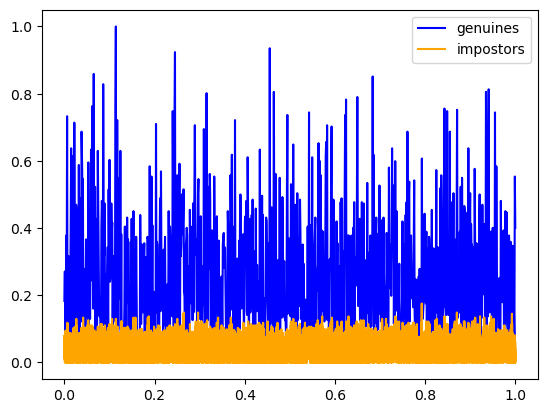

In [35]:
"""Plot the genuine and imposter score distributions."""

genuines_scores = li_scores[li_genuine_id == 1]
impostors_scores = li_scores[li_genuine_id == 0]

print(genuines_scores)
#print(impostors_scores.size)
#print(li_scores.size)
#print(li_scores)

elems1 = (np.arange(0, genuines_scores.size))
elems1_normalized = elems1/(elems1.max())
elems2 = (np.arange(0, impostors_scores.size))
elems2_normalized = elems2/(elems2.max())

#print(elems1_normalized)
#print(elems2_normalized)

#plt.figure(1)
plt.plot(elems1_normalized, genuines_scores, label='genuines', color='blue')
#plt.legend()
#fig1.show()

#plt.figure(2)
plt.plot(elems2_normalized, impostors_scores, label='impostors', color='orange')
plt.legend()
#fig2.show()
plt.show()


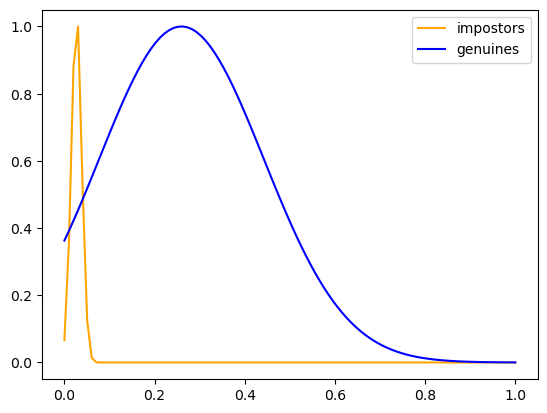

In [36]:
# Impostor distribution parameters
mean_impostor = impostors_scores.mean()
variance_impostor = impostors_scores.var()
sigma_impostor = math.sqrt(variance_impostor) 

# x axis for gaussian distribution
#impostors = np.linspace(mean_impostor - 3*sigma_impostor, mean_impostor + 3*sigma_impostor, 100)
impostors = np.linspace(start=0, stop=1, num=100)

# y axis: Normalize the probabilities for better visualization
prob_impostors = stats.norm.pdf(impostors, mean_impostor, sigma_impostor)
prob_impostors = prob_impostors / prob_impostors.max()
# preprocessing.normalize([stats.norm.pdf(impostors, mean_impostor, sigma_impostor)])[0]

plt.plot(impostors, prob_impostors, label='impostors', color='orange')

# Genuine distribution parameters
mean_genuine = genuines_scores.mean()
variance_genuine = genuines_scores.var()
sigma_genuine = math.sqrt(variance_genuine) 

# x axis for gaussian distribution
#genuines = np.linspace(mean_genuine - 3*sigma_genuine, mean_genuine + 3*sigma_genuine, 100)
genuines = np.linspace(0, 1, 100)

# y axis: Normalize the probabilities for better visualization
prob_genuines = stats.norm.pdf(genuines, mean_genuine, sigma_genuine)
prob_genuines = prob_genuines / prob_genuines.max()

plt.plot(genuines, prob_genuines, label='genuines', color='blue')

plt.legend()
plt.show()

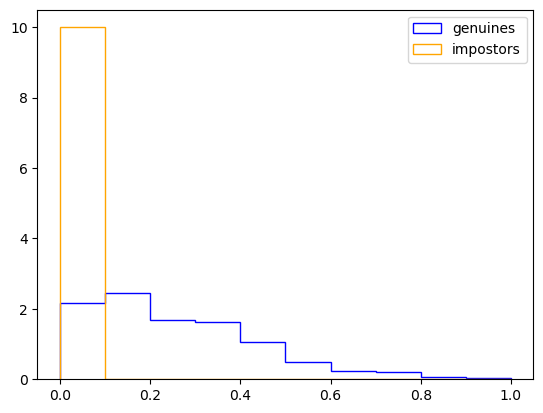

In [18]:
plt.hist(genuines_scores, label='genuines', color='blue', range=(0,1), density=True, histtype='step')
plt.hist(impostors_scores, label='impostors', color='orange', range=(0,1), density = True, histtype='step')

plt.legend()
plt.show()

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

The 'false accept' and 'false reject' regions in the illustration above are quantified using the False Match/Acceptance Rates (FMR/FAR) and False Non-Match/Rejections Rates (FNMR/FRR). The FMR and FNMR can easily be computed given the previously calculated probability distributions and a threshold value $\eta$. Practically this boils down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute:
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta),
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s < \eta).
$$

We can also compute the Genuine Acceptance Rate (GAR)/True Match Rate (TMR) as:
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta).
$$

Note that choosing a threshold is always a tradeof between FMR and FNMR. <br>
<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR), sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR). 

<img src="img/ROC.png" width="700" height="auto" align="center"/>

<div class="alert alert-block alert-success">
<b>Q2: </b> ROC Curves
<ul>
    <li>Calculate FPR, TPR from the matching scores.</li>
    <li>Plot FAR and FRR as a function of matching scores.</li>
    <li>Plot the ROC curve. Plot for linear and logarithmic scale if needed. What do you observe?</li>
    <li>Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?</li>
</ul>  
</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/index.html">scikit-learn</a> package, it contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</div>

In [19]:
y_labels = li_genuine_id
y_scores = li_scores

[2.         1.         0.8129771  ... 0.01526718 0.01145038 0.        ]


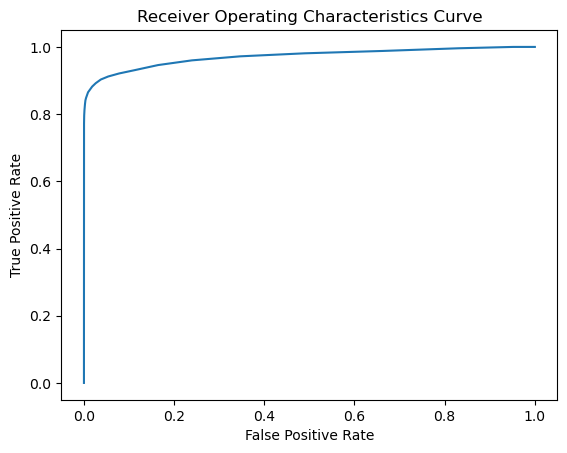

In [20]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_labels, y_scores)
#print(fpr)
#print(tpr)
print(thresholds)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics Curve')
plt.show()

In [21]:
"""Calculate FPR, TPR from the matching scores."""

"""
thresholds = np.arange(0,1)

successful_impostors = impostors[impostors >= threshold]
successful_genuines = genuines[genuines >= threshold]

number_of_positives = successful_impostors.size + successful_genuines.size

print("FPR: " + str(successful_impostors.size/impostors.size))
print("TPR: " + str(successful_genuines.size/genuines.size))
"""

print(fpr)
print(tpr)


[0.         0.         0.         ... 0.95205205 0.99648348 1.        ]
[0.    0.001 0.007 ... 1.    1.    1.   ]


[1.    0.999 0.993 ... 0.    0.    0.   ]


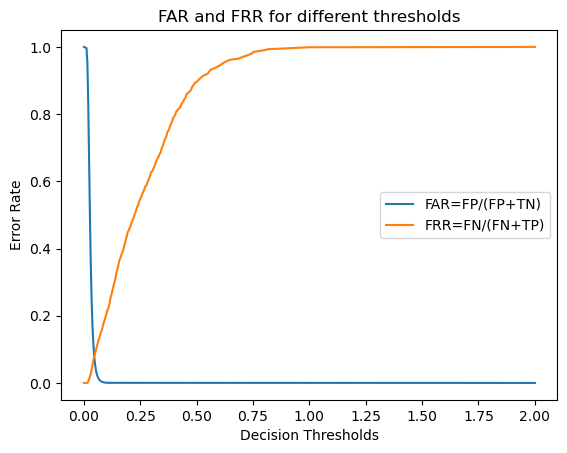

In [22]:
"""Plot FAR and FRR as a function of the decision threshold."""
# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR

frr = 1-tpr
print(frr)

plt.plot(thresholds, fpr, label='FAR=FP/(FP+TN)')
plt.plot(thresholds, frr, label='FRR=FN/(FN+TP)')
plt.xlabel("Decision Thresholds")
plt.ylabel("Error Rate")
plt.title('FAR and FRR for different thresholds')
plt.legend()
plt.show()


In [23]:
"""plot the ROC curve (TPR against the FPR for different threshold values)"""


'plot the ROC curve (TPR against the FPR for different threshold values)'

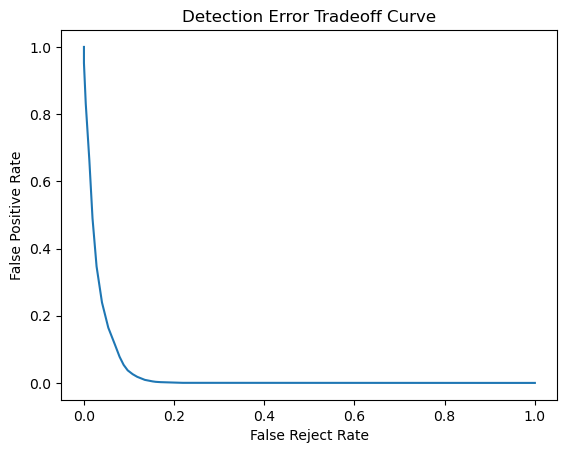

In [24]:
plt.plot(frr, fpr)
plt.xlabel("False Reject Rate")
plt.ylabel("False Positive Rate")
plt.title('Detection Error Tradeoff Curve')
plt.show()

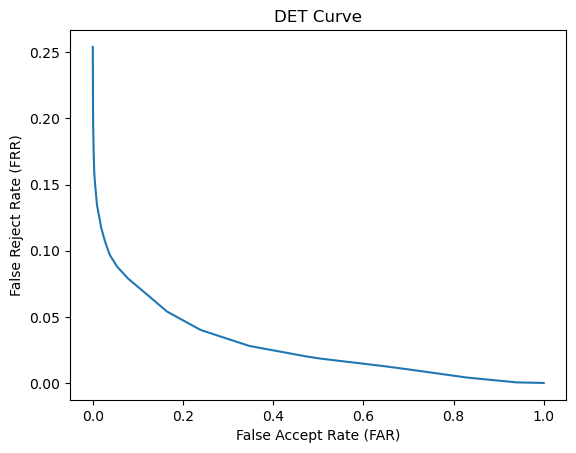

In [26]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""

# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR

from scipy.interpolate import interp1d

# Interpolate (map) function to map the values of fpr to the values of frr linearly
f = interp1d(fpr, frr, kind='linear')

# Compute the logarithms of far and fpr to get a better visualization
log_fpr = np.logspace(-4, 0, fpr.size)
log_frr = f(log_fpr)
#print(log_fpr)
#print(log_frr)

# Plot the DET curve
plt.plot(log_fpr, log_frr)
#plt.xscale('log')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.title('DET Curve')
#plt.grid()
plt.show()


#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

<div class="alert alert-block alert-success">
<b>Q3: </b> Classification Metrics
<ul>
    <li>Plot F1 and accuracy as a function of the decision thresholds on the similarity score.</li>
    <li>Calculate the threshold and accuracy for which F1 is maximal. Is it an interesting operating point?</li>
    <li>Do the same for the classification error (accuracy). Is there a difference?</li>
    <li>Is accuracy a good performance metric in this case?</li>
</ul>  
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics">scikit-learn classification metrics</a> to assist.
</div>


In [27]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for Â± 50 threshold values should suffice

f1s = []
accuracies = []

thresholds_subset = thresholds[100:150] # The thresholds ranging between 0.2 and 0
print(thresholds.size)
print(thresholds_subset)

threshold_f1_max = 0
threshold_acc_max = 0
f1_max = 0
acc_max = 0

for threshold in thresholds_subset:
    predictions = (y_scores >= threshold).astype(int)
    f1 = f1_score(y_labels, predictions)
    f1s.append(f1)
    accuracy = accuracy_score(y_labels, predictions)
    accuracies.append(accuracy)
    if(f1_max < f1):
        f1_max = f1
        threshold_f1_max = threshold
    if(acc_max < accuracy):
        acc_max = accuracy
        threshold_acc_max = threshold
    
#print(f1s)
#print(accuracies)

149
[0.20229008 0.19847328 0.19465649 ... 0.01526718 0.01145038 0.        ]


In [28]:
"""Calculate the threshold for which F1 is maximal."""

print("F1 Max: " + str(f1_max))
print("Threshold F1 Max: " + str(threshold_f1_max))
print("Acc Max: " + str(acc_max))
print("Threshold Acc Max: " + str(threshold_acc_max))


F1 Max: 0.8208027133973996
Threshold F1 Max: 0.12595419847328243
Acc Max: 0.999683
Threshold Acc Max: 0.12595419847328243


In [29]:
"""Do the same for the classification error (or accuracy)"""

"""
It's the same threshold for both of them.

The accuracy can be a misleading metric in our example since there is a high class imbalance and 
labeling most classes as negative until a certain threshold, provides a significantly high accuracy rate (%99).

Therefore, it makes more sense to use other metrics such as the f1 score.
Below are the formulas for f1 score and accuracy score, which highlights their difference:

precision = true positives / (true positives + false positives)
recall = true positives / (true positives + false negatives)

f1_score = 2 * (precision * recall) / (precision + recall)
accuracy =  true classifications (tp + tn) / whole dataset

As we can see, with accuracy score, we can in a way get away by being very strict and rejecting a majority 
of the dataset and still get a high accuracy. To be more precise, we should reject the majority of the dataset 
in our case, but the accuracy score fails to properly show our performance.

Therefore, the f1 score provides a much better metric to measure the performance since:

1- It focuses only on the positive classes and not the whole dataset (since the whole dataset is imbalanced)
2- It considers both false negatives and false positives. Recall prevents us from being too strict and 
precision prevents us from giving too much leeway.

"""

"\nIt's the same threshold for both of them.\n\nThe accuracy can be a misleading metric in our example since there is a high class imbalance and \nlabeling most classes as negative until a certain threshold, provides a significantly high accuracy rate (%99).\n\nTherefore, it makes more sense to use other metrics such as the f1 score.\nBelow are the formulas for f1 score and accuracy score, which highlights their difference:\n\nprecision = true positives / (true positives + false positives)\nrecall = true positives / (true positives + false negatives)\n\nf1_score = 2 * (precision * recall) / (precision + recall)\naccuracy =  true classifications (tp + tn) / whole dataset\n\nAs we can see, with accuracy score, we can in a way get away by being very strict and rejecting a majority \nof the dataset and still get a high accuracy. To be more precise, we should reject the majority of the dataset \nin our case, but the accuracy score fails to properly show our performance.\n\nTherefore, the f1

#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

<img src="img/EER.png" width="300" height="300"/>

<div class="alert alert-block alert-success">
<b>Q4: </b> AUC, EER and alternatives
<ul>
    <li>Calculate ROC AUC. Is this a good metric? What does it reveal about the system? </li>
    <li>Calculate (by approximation) the EER and plot it on the FAR-FRR curve. Is this a good peration point?</li>
    <li>Calculate the decision threshold for which the sum of FRR and FAR is minimal. Is this point similar to the total classification error?</li> 
    <li>Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.</li>
</ul>  
</div>


In [30]:
"""Calculate the ROC AUC."""

print("ROC Area Under the Curve Score: " + str(roc_auc_score(y_labels,y_scores)))

"""
A higher AUC score indicates that the curve leans more towards the top left, meaning that
the classifer operates better. A score of 0.5 means that the classifier cannot distinguish the two classes 
and the prediction is basically the same as a coin toss
"""

ROC Area Under the Curve Score: 0.9712470650650651


'\nA higher AUC score indicates that the curve leans more towards the top left, meaning that\nthe classifer operates better. A score of 0.5 means that the classifier cannot distinguish the two classes \nand the prediction is basically the same as a coin toss\n'

FPR point at EER : 0.07793493493493493
FRR point at EER : 0.07899999999999996
EER is: 0.07846746746746744


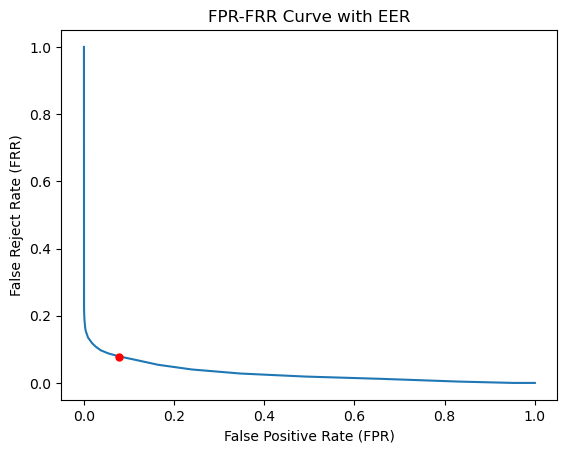

In [31]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - avoid using a library that directly computes the EER for this assignment 

min_distance = float('inf')
min_accuracy = 0
eer_threshold = 0
eer_index = 0
distances = np.array([])

for i, threshold in enumerate(thresholds):
    distance = abs(fpr[i] - frr[i])
    accuracy = accuracy_score(y_labels, predictions)
    distances = np.append(distances, distance)
    if distance < min_distance:
        min_distance = distance
        eer_threshold = threshold
        eer_index = i
        min_accuracy = accuracy
        
print("FPR point at EER : " + str(fpr[eer_index]))
print("FRR point at EER : " + str(frr[eer_index]))

eer = (fpr[eer_index] + frr[eer_index]) / 2

print("EER is: " + str(eer))

# Plot the EER on the FPR-FRR curve
plt.plot(fpr, frr)
#plt.plot(fpr, tpr)
plt.plot(eer, eer, marker='o', markersize=5, color='red')
#plt.plot(eer, 1-eer, marker='o', markersize=5, color='red')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Reject Rate (FRR)')
#plt.ylabel('True Positive Rate (TPR)')
plt.title('FPR-FRR Curve with EER')
plt.show()


0.04580152671755725
0.12595419847328243


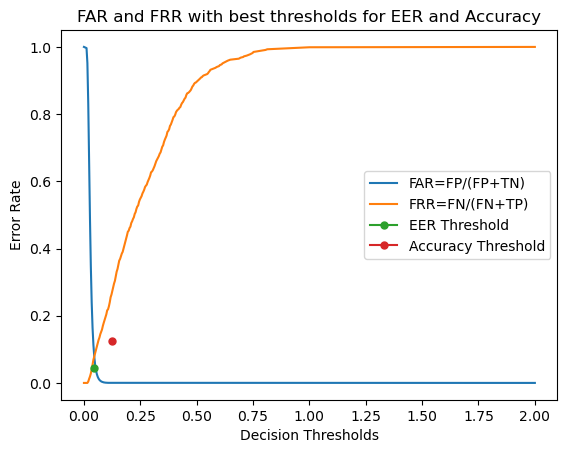

In [32]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
# hint: same as above

#print(distances)
#distances.sort()
#print(distances)
print(eer_threshold)
print(threshold_acc_max)

plt.plot(thresholds, fpr, label='FAR=FP/(FP+TN)')
plt.plot(thresholds, frr, label='FRR=FN/(FN+TP)')
plt.plot(eer_threshold, eer_threshold, marker='o', markersize=5, label="EER Threshold")
plt.plot(threshold_acc_max, threshold_acc_max, marker='o', markersize=5, label="Accuracy Threshold")
plt.xlabel("Decision Thresholds")
plt.ylabel("Error Rate")
plt.title('FAR and FRR with best thresholds for EER and Accuracy')
plt.legend()
plt.show()

In [ ]:
"""
As visible in the graph, the EER threshold provides a much better approximation than the accuracy threshold.

The reason for that is: 

"""

#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


<div class="alert alert-block alert-success">
<b>Q5: </b> Precision-Recall curves and related summary measures
<ul>
    <li>Calculate and plot the Precision-Recall curve for this system. What does it reveal about the performance of the system?</li>
    <li>Calculate the Area Under the PR-curve. Discuss.</li>
    <li>Calculate the average precision scores. Discuss its value.</li> 
</ul>  
</div>


[0.01526718 0.01908397 0.02290076 ... 0.92366412 0.9351145  1.        ]
[0.00105031 0.00119822 0.00149099 ... 1.         1.         1.        ]
[1.    0.996 0.988 ... 0.002 0.001 0.   ]


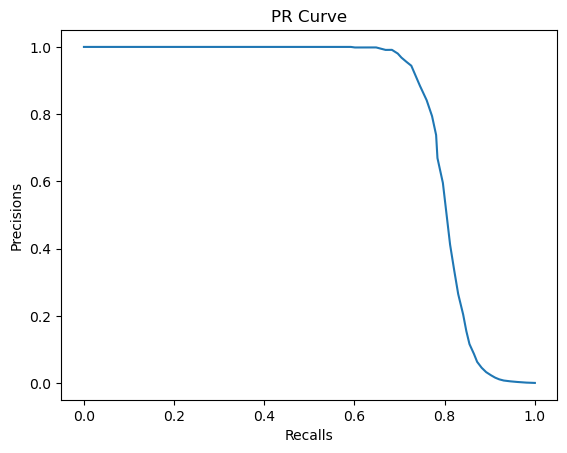

In [33]:
"""Calculate and plot the Precision-Recall curve for this system"""

from sklearn.metrics import precision_recall_curve, auc, average_precision_score

precisions, recalls, thresholds = precision_recall_curve(y_labels, y_scores)

print(thresholds)
print(precisions)
print(recalls)

plt.plot(recalls, precisions)
plt.xlabel("Recalls")
plt.ylabel("Precisions")
plt.title("PR Curve")
plt.show()

In [34]:
"""
The Precision-Recall curve reveals how well the system performs at different classification thresholds. 
In general, a good system should have high Precision and high Recall, 
which means that it correctly identifies most of the positive instances and avoids falsely 
classifying negative instances as positive. However, there is often a trade-off between Precision and Recall,
as increasing one metric may come at the cost of decreasing the other. 
The Precision-Recall curve can help us visualize this trade-off and 
choose the optimal classification threshold for our particular use case.
"""

'\nThe Precision-Recall curve reveals how well the system performs at different classification thresholds. \nIn general, a good system should have high Precision and high Recall, \nwhich means that it correctly identifies most of the positive instances and avoids falsely \nclassifying negative instances as positive. However, there is often a trade-off between Precision and Recall,\nas increasing one metric may come at the cost of decreasing the other. \nThe Precision-Recall curve can help us visualize this trade-off and \nchoose the optimal classification threshold for our particular use case.\n'

In [35]:
"""Calculate the Area Under the PR-curve."""
auc_pr = auc(recalls, precisions)
print(auc_pr)

0.8034780801507487


In [36]:
"""Calculate the average precision scores"""
print(precisions.mean())
print(average_precision_score(y_labels, y_scores))

"""??????????????????????"""

0.8865123884028598
0.7988972537365139


'??????????????????????'

## III. Validation of identification system 

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



<div class="alert alert-block alert-success">
<b>Q6: </b> CMC curves
<ul>
    <li>Calculate the Cumulative Matching Characteristic curve (implement this yourself)</li>
    <li>Compute the Rank-1 Recognition Rate.</li>
</ul>  
</div>


[0.858 0.917 0.938 0.957 0.963 ... 1.    1.    1.    1.    1.   ]


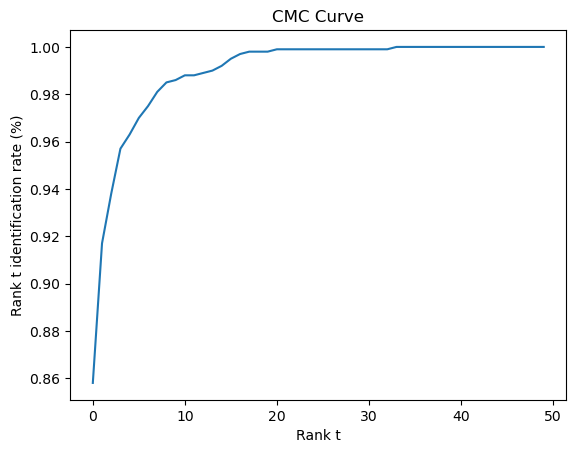

In [108]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library

def calculate_cmc(similarity_matrix, true_labels, max_rank):
    # Sort the similarity matrix in descending order based on the matched/predicted ids
    sorted_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1]
    sorted_labels = true_labels[sorted_indices]
    
    # Calculate the cumulative match curve for each rank
    cmc = np.zeros(max_rank)
    for i in range(len(true_labels)):
        matches = (sorted_labels[:, :max_rank] == true_labels[i])
        #print(matches.shape)
        matches_cumsum = np.cumsum(matches, axis=1)
        #print(matches_cumsum)
        cmc += np.any(matches_cumsum, axis=0)
        #print(cmc)
        #print(cmc.shape)
    cmc /= len(true_labels)
    print(cmc)
    
    """
    # Calculate the rank-t recognition rate
    t = 50
    for i in range(0, t):
        for j in range(0, i)
            if(s)
        top1_matches = sorted_labels[:, 0] == true_labels
    rank1_acc = np.sum(top1_matches) / len(true_labels)
    """
    
    return cmc

#print(np.array(li_similarity_matrix.index))

max_rank = 50
cmc_array = calculate_cmc(np.array(li_similarity_matrix), np.array(li_similarity_matrix.index), max_rank)

x_axis = np.arange(0, max_rank)
plt.plot(x_axis, cmc_array)
plt.xlabel("Rank t")
plt.ylabel("Rank t identification rate (%)")
plt.title("CMC Curve")
plt.show()

In [ ]:
"""compute the Rank-1 Recognition Rate."""

rank1_acc = cmc_array[0]
print(rank1_acc)

<div class="alert alert-block alert-success">
<b>Q7: </b> Evaluate different biometric systems
<ul>
    <li>Use above evaluation techniques to compare the biometric system based on the left index to the right index </li>
    <li>Do you see any differences in any of the curves or measures?</li>
</ul>  
</div>

## IV. Assignment Instructions
For this assignment you have to submit a report (.pdf) and the implementation of this notebook (.ipynb) to toledo. The report should be between 3-8 pages (more pages $\nRightarrow$ higher score) and should be structured around the posed questions (Q1,...). The text should demonstrate your understanding of the material and, depending on the question, clearly introduce the context, technique, your expectation and interpretation of the results. Do not limit yourselves to just answering the questions. Feel free to add figures and, if needed, some *small* code snippet to clarify your position. **The report should be self contained, the notebook functions as supplementary material only!**

*Note: Make sure you include all the files required to run the notebooks on submission.* <br>
